# Fake News detection project

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from wordcloud import WordCloud # type: ignore
from collections import Counter
import nltk
from nltk.corpus import stopwords # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import string

warnings.filterwarnings("ignore")

#### Import data

ISOT Dataset

In [3]:
df_true = pd.read_csv("./data/True.csv", encoding="utf-8")
df_fake = pd.read_csv("./data/Fake.csv", encoding="utf-8")

df_true["label"] = "TRUE"
df_fake["label"] = "FAKE"

# combine both datasets into one
df = pd.concat([df_true, df_fake], ignore_index=True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE


#### Data Analysis

In [4]:
print(f"Dataset shape :{df.shape}")
print(f"There are {len(df.columns)} columns: {df.columns}")
print(df.info())
print(df.isnull().sum())
df.describe(include='all')

Dataset shape :(44898, 5)
There are 5 columns: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None
title      0
text       0
subject    0
date       0
label      0
dtype: int64


,title,text,subject,date,label
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",FAKE
freq,14,627,11272,182,23481


In [5]:
custom_palette = {
    'FAKE': 'indianred', # '#FF6347',
    'TRUE': 'lightgreen'# '#4CAF50'
}

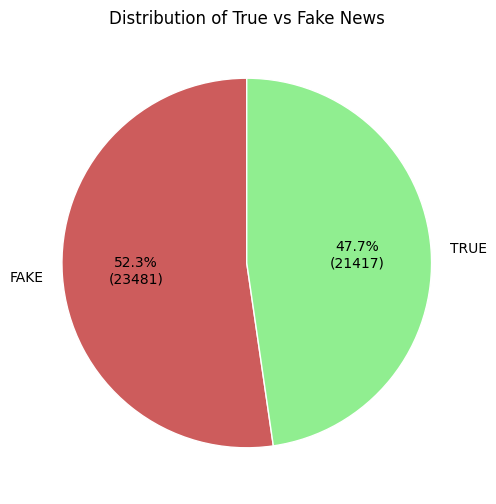

In [6]:
# Pie chart of True vs Fke counts
label_counts = df['label'].value_counts()

# formatting function for labels
def format_label(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(6, 6))
colors = [custom_palette[label] for label in label_counts.index]
plt.pie(label_counts, labels=label_counts.index, startangle=90, wedgeprops={'edgecolor': 'white'},
        autopct=lambda pct: format_label(pct, label_counts), colors=colors)
plt.title("Distribution of True vs Fake News")
plt.show()

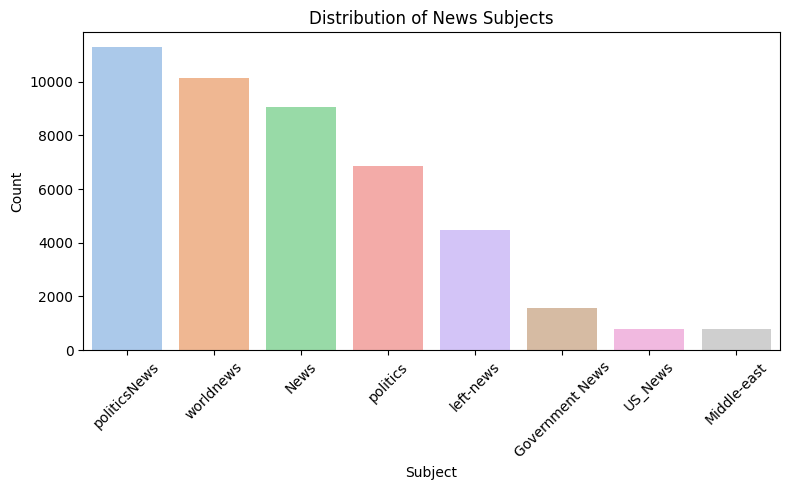

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [7]:
# Bar plot of the different subjects of articles
subject_counts = df['subject'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='pastel')
plt.title("Distribution of News Subjects")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df['subject'].value_counts()

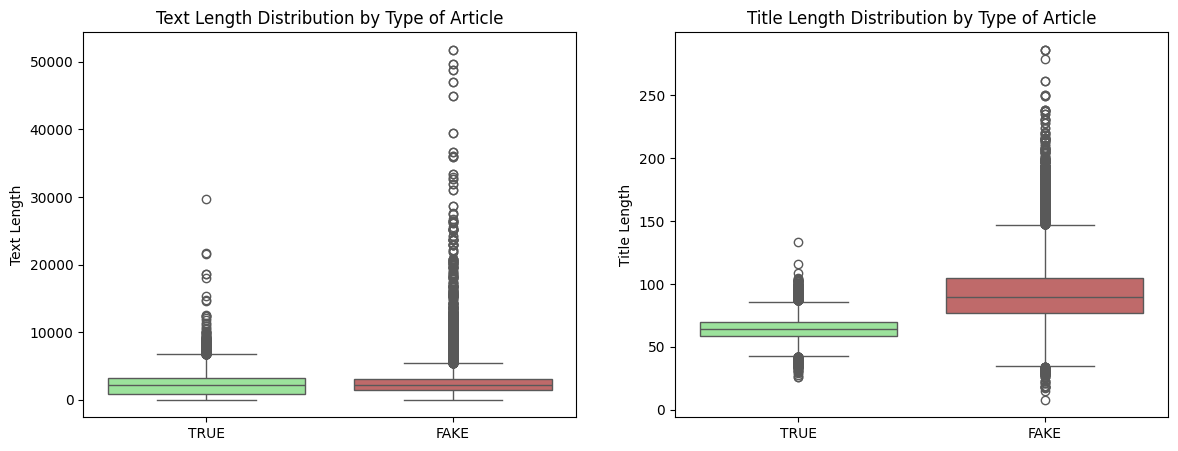

In [8]:
# Box plots for fake vs Truetext length and title length distributions

df['text_length'] = df['text'].apply(len)
df['title_length'] = df['title'].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='label', y='text_length', palette=custom_palette, hue='label', ax=axes[0])
axes[0].set_title("Text Length Distribution by Type of Article")
axes[0].set_xlabel("")
axes[0].set_ylabel("Text Length")

sns.boxplot(data=df, x='label', y='title_length', palette=custom_palette, ax=axes[1])
axes[1].set_title("Title Length Distribution by Type of Article")
axes[1].set_ylabel("Title Length")
axes[1].set_xlabel("")

plt.show()

##### Topic exploration
To get a global idea of what topics the speeches treat of
- Word Frequency Analysis and Word Cloud Visualization using word counts and TFIDF Vectorizer


In [9]:
nltk.download('stopwords')

# join all articles' texts for true and fake news :
true_text = ' '.join(df[df.label == 'TRUE']['text'])
fake_text = ' '.join(df[df.label == 'FAKE']['text'])
# combine all articles :
# all_text = ' '.join([true_text, fake_text])

# Normalize to lowercase and count word frequencies
true_words = [word.lower() for word in true_text.split()]
true_word_counts = Counter(true_words)
fake_words = [word.lower() for word in fake_text.split()]
fake_word_counts = Counter(fake_words)

# Filter out common stopwords (in english)
stop_words = set(stopwords.words("english"))
true_filtered_word_counts = {word: count for word, count in true_word_counts.items() if word not in stop_words}
fake_filtered_word_counts = {word: count for word, count in fake_word_counts.items() if word not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To reduce the impact over large tfidf coefficients, we use the log transformation $x \rightarrow log(1+x)$

In [10]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=15, # appears in at least 15 docs
    max_df=0.8, # not appear in more than 80% of the doc
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{4,}\b", # removes numbers
    max_features=5000
)

X_ = vectorizer.fit_transform(df_true['text'])
cols = vectorizer.get_feature_names_out()
true_tfidf_matrix = X_.toarray() # convert the TF-IDF matrix as a dense array
true_tfidf = pd.DataFrame(np.log1p(true_tfidf_matrix), columns=cols) #index=df["text"].index,

X_ = vectorizer.fit_transform(df_fake['text'])
cols = vectorizer.get_feature_names_out()
fake_tfidf_matrix = X_.toarray() # convert the TF-IDF matrix as a dense array
fake_tfidf = pd.DataFrame(np.log1p(fake_tfidf_matrix), columns=cols) # index=df["text"].index, 


# Calculate the sum of the TF-IDF scores for each term across all articles
sum_tfidf_scores_true = true_tfidf_matrix.sum(axis=0)
sum_tfidf_scores_fake = fake_tfidf_matrix.sum(axis=0)
# Create a dictionary with words as keys and their total TF-IDF score as values
word_freq_true = dict(zip(cols, sum_tfidf_scores_true))
word_freq_fake = dict(zip(cols, sum_tfidf_scores_fake))

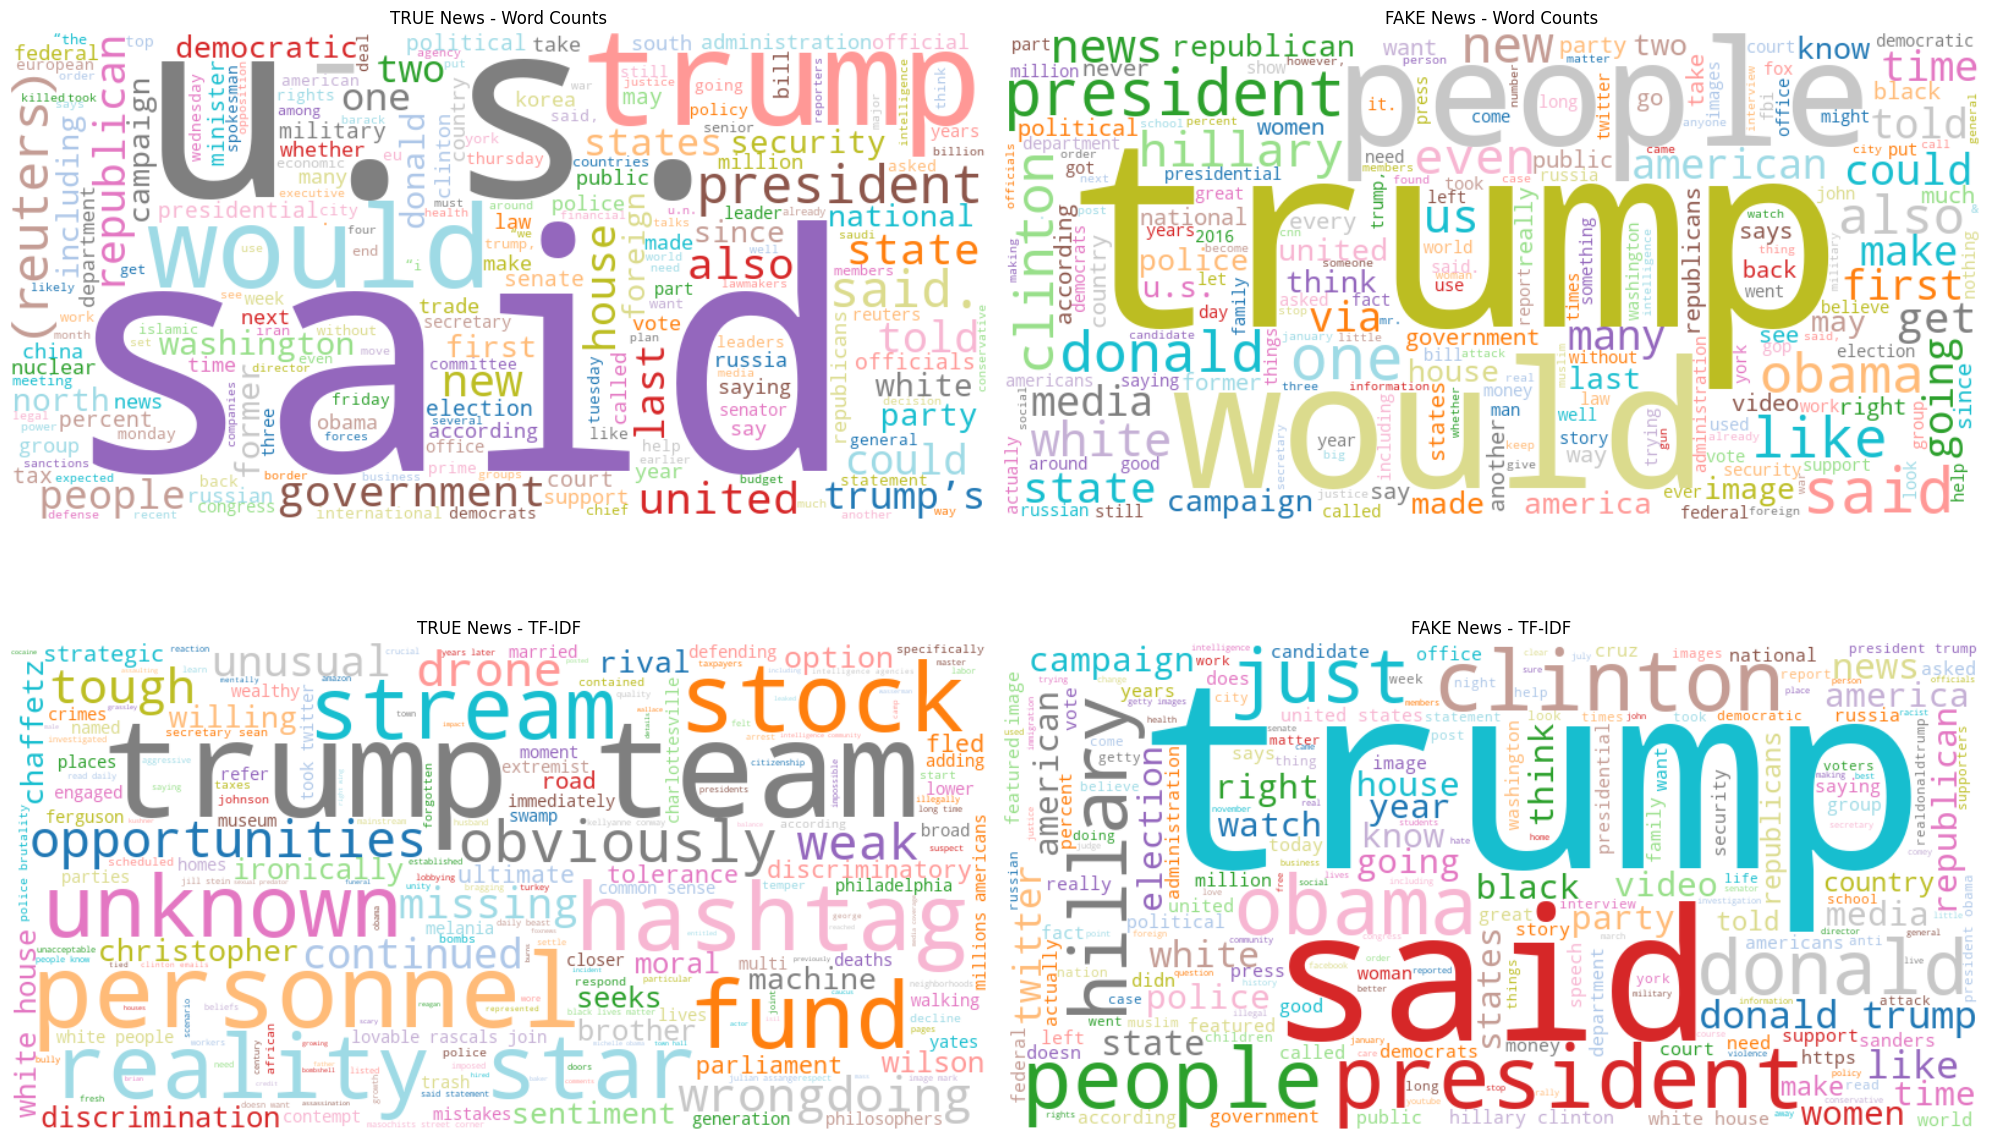

In [64]:
# Generate word clouds
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# according to word counts
wordcloud_counts_true = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(true_filtered_word_counts)
wordcloud_counts_fake = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(fake_filtered_word_counts)

# according to TF-IDF scores
wordcloud_tfidf_true = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq_true)
wordcloud_tfidf_fake = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq_fake)

# plot
axes[0, 0].imshow(wordcloud_counts_true, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('TRUE News - Word Counts')

axes[0, 1].imshow(wordcloud_counts_fake, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('FAKE News - Word Counts')

axes[1, 0].imshow(wordcloud_tfidf_true, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('TRUE News - TF-IDF')

axes[1, 1].imshow(wordcloud_tfidf_fake, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('FAKE News - TF-IDF')


plt.subplots_adjust(hspace=1, wspace=30)

plt.tight_layout()
plt.show()

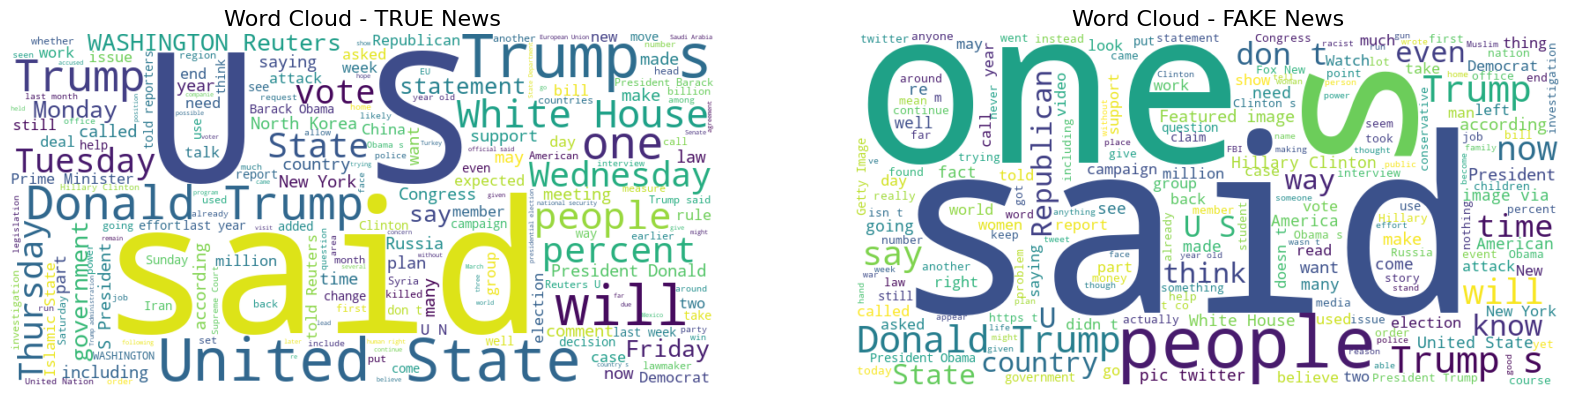

In [8]:
# # Wordclouds for Fake vs True articles


# fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# for ax, (text, title) in zip(axes, [(true_text, "TRUE News"), (fake_text, "FAKE News")]):
#     wc = WordCloud(width=800, height=400, background_color='white').generate(text)
#     ax.imshow(wc, interpolation='bilinear')
#     ax.axis('off')
#     ax.set_title(f'Word Cloud - {title}', fontsize=16)

# # plt.tight_layout()
# plt.show()

In [65]:
import re

def get_top_n_words(corpus, n=None):
    words = re.findall(r'\b\w+\b', corpus.lower())
    return Counter(words).most_common(n)

print("Top 20 REAL words:")
print(get_top_n_words(true_text, 20))

print("\nTop 20 FAKE words:")
print(get_top_n_words(fake_text, 20))


Top 20 REAL words:
[('the', 482468), ('to', 245734), ('of', 205275), ('a', 198580), ('and', 182081), ('in', 181652), ('s', 141421), ('on', 108594), ('said', 99062), ('that', 88237), ('for', 79895), ('is', 55494), ('trump', 54700), ('with', 54504), ('he', 54370), ('it', 49590), ('by', 47949), ('was', 47946), ('as', 47330), ('has', 46246)]

Top 20 FAKE words:
[('the', 543551), ('to', 290819), ('of', 236640), ('and', 226971), ('a', 214783), ('in', 171163), ('that', 151662), ('s', 141155), ('is', 111234), ('for', 93480), ('on', 83591), ('it', 83380), ('trump', 79300), ('he', 78997), ('was', 67857), ('with', 63419), ('his', 58351), ('this', 58217), ('as', 57768), ('be', 49271)]
